In [67]:
import matplotlib.pyplot as plt
from random import randint
import scipy.stats as st
import networkx as nx
import numpy as np
import random
import heapq

In [68]:
def find_weights(f_node, s_node):
    """
    The road system connects farms, the waste removal company, 
    and the waste drop-off sites.
    
    This function takes two nodes on this model and 
    returns the weight (distance) between them.
    """
    return farm_sites_dict[f_node] + farm_sites_dict[s_node]

def waste_production_rate(node_chosen):
    """
    In the waste removal model, different farms have different
    average rates of waste production, so there will be more waste
    on some days than other days.
    
    This function obtains rate of waste production
    """
    # Initilize the waste production rate
    waste_production = 0.2
    
    # Waste produced is related to population at nodes (increases/decreases based on population) 
    waste_produced = (node_population[node_chosen]/500) * waste_production
    
    return 60/waste_produced

def drop_off_sites(network, no_sites):
    """
    The function determines a location for the drop-off site 
    at random positions in the network.
    """
    distribution = {}
    
    nodes = list(network.nodes())
    
    for i in range(no_sites):
        position = random.choice(nodes) # Chooses a node from network
        nodes.remove(position)
        distribution[position] = True # Establishes a certain node with a drop-off site

    for i in range(len(nodes)):
        position = random.choice(nodes)
        nodes.remove(position)
        distribution[position] = False # Determines that there are no drop-off sites in the nodes

    return distribution

In [69]:
# Nodes here include the farm sites (that may or may not
# contain a drop-off site) connected in the network
farm_nodes = ["farm1", "farm2", "farm3", "farm4", 
              "farm5", "farm6", "farm7", 
              "farm8", "farm9", "farm10"]

# Assigned values to the nodes in the network for determine weights later
farm_sites_dict = {"farm1": 0.2, "farm2": 0.8,
                   "farm3": 1, "farm4": 0.6,
                   "farm5": 1.5, "farm6": 0.9,
                   "farm7": 0.3, "farm8": 1.2,
                   "farm9": 0.4, "farm10": 2}

node_population = {"farm1": 15000, "farm2": 75000,
                   "farm3": 20000, "farm4": 80000,
                   "farm5": 45000, "farm6": 70000,
                   "farm7": 40000, "farm8": 60000,
                   "farm9": 35000, "farm10": 25000}

# Connect farms that have a direct route (an edge) between each other
connected_farms = [["farm1", "farm10"], ["farm1", "farm3"],
                   ["farm2", "farm10"], ["farm2", "farm4"],
                   ["farm3", "farm9"], 
                   ["farm4", "farm5"], ["farm4", "farm6"], ["farm4", "farm8"],
                   ["farm5", "farm8"],
                   ["farm6", "farm1"],
                   ["farm7", "farm9"], ["farm7", "farm10"],
                   ["farm8", "farm9"],
                   ["farm9", "farm10"]]

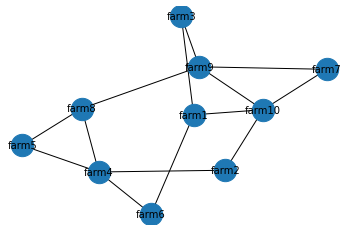

The farm sites network has 10 nodes and 14 edges


In [70]:
# Create graphs of farm sites
farm_sites = nx.Graph()

# Add edges between nodes from the previously made dictionaries
for farm in connected_farms:
    farm_sites.add_edge(farm[0], farm[1], weight = find_weights(farm[0], farm[1]))

# Include attributes of each of the nodes in the network
for node in farm_sites.nodes():
    farm_sites.nodes[node]['population'] = node_population[node]
    farm_sites.nodes[node]['weight'] = farm_sites_dict[node]
    farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
    farm_sites.nodes[node]['waste_truck'] = random.choice([True, False])

# Plotting the farm sites graph
pos = nx.spring_layout(farm_sites) 

# Draw the nodes of respective farm sites
nx.draw_networkx_nodes(farm_sites, pos, node_size = 500)

# Draw the edges of the network
nx.draw_networkx_edges(farm_sites, pos)

# Include labels for the sites
nx.draw_networkx_labels(farm_sites, pos, font_size = 10)
plt.axis("off")

plt.show()

print(f'The farm sites network has {farm_sites.number_of_nodes()} nodes '
      f'and {farm_sites.number_of_edges()} edges')

In [71]:
class Event:
    '''
    A class that handles Events and important aspects including time that they take place
    '''
    def __init__(self, timestamp, function, *args, **kwargs):

        # Variables for the timestamp of the event
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        
        '''
        To determine the schedule of events and the order. The events have
        timestamps to help determine this order.
        '''
        # Determines boolean value to have an event set
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        To run the event given the parameters 
        '''
        # Runs the function with params passed
        self.function(schedule, *self.args, **self.kwargs)

In [72]:
class Schedule:
    '''
    A class that handles the schedule of the events, it organizes
    and selects the events. Helps create events and finding other events.
    Tracks the time of the simulation.
    '''
    
    def __init__(self):
        
        # Initialize the time of simulation
        self.now = 0

        # To hold the events in the schedule
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):

        # Add event and push to the queue of events
        heapq.heappush(self.priority_queue, Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        
        # Add event to schedule after interval period
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        
        # Next event in the queue
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        
        # Run simulation and update time
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        
        # Returns representation of simulation
        return (f'Schedule() at time {self.now} ' + f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):

        # Printing events in schedule
        print(repr(self))
        
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [73]:
class WasteRemovalNetwork: 
    """
    The waste removal company has trucks that
    visit the farms (nodes in the network), collect waste and drop-off.

    This WasteRemovalNetwork class handles waste collection and record time.
    """
    
    def __init__(self, network, printing = False):

        # the network of nodes of different farmsites 
        self.network = network

        # the waste truck collection determines the process of the waste trucks
        self.waste_truck_collection = 2

        # keep the time it takes to collect waste at different nodes 
        self.waste_collection_time = []

        # determines the quantity of waste to collect
        self.waste_to_collect = 0

        # the waste truck take on average this amount of time to collect waste
        self.collection_time_mean = 20

        # the waste truck time can vary by some measure of standard deviation
        self.collection_time_std = 5

        # introduce more probabilistic randomness into the time to collect 
        self.additional_time_mean = 10
        self.additional_time_std = 3
        self.probabilistic_randomness = 15

        # the waste truck might have to drive to another farm
        self.collection_queue = []

        # determines the drop off site for a waste truck
        self.drop_off_site = []

        # determines the length of the queue for waste collection
        self.length_of_queue = []

        # this determines status of the drop off site 
        self.drop_off_available = []

        # boolean, can be changed between True and False, default is False
        self.printing = printing
        
        # determines if there is a drop off site based on availability of waste trucks
        for farm_site in farm_sites.nodes():
            if self.network.nodes[farm_site]['waste_truck']:
                self.drop_off_site.append(farm_site)
    
    def begin_waste_collection(self, schedule, initial_farm_node, final_farm_node):
        """
        In this model, the waste collection process begins after the params are such
        that the node requires the waste to be collected
        """
        # The printing variable is boolean that can be True or False
        if self.printing:
            print(f"Waste collection from truck at {initial_farm_node} to collect at {final_farm_node}")
        
        # Counter for nodes where there is waste to collect increase 
        self.waste_to_collect += 1

        # The node is removed from available dropp_off_sites 
        try:
            self.drop_off_site.remove(initial_farm_node)
        except ValueError:
            pass

        # Self.drop_off_site.remove(initial_farm_node)
        self.network.nodes[initial_farm_node]['waste_truck'] = False
        
        # Include probabilistic randomness introduced by additional time 
        include_additional_time = 0

        # Determine if additional time is needed
        if randint(0, 100) <= self.probabilistic_randomness:
            
            # Determine additional time from normally distributed values
            include_additional_time = np.random.normal(self.additional_time_mean, self.additional_time_std)
        
        # Collection_time is the total time it takes to collect the waste at a node
        collection_time = np.random.normal(self.collection_time_mean, self.collection_time_std)
        calculated_time_of_arrival = self.time_of_arrival(initial_farm_node, final_farm_node)*2 
        total_collection_time = calculated_time_of_arrival + collection_time + include_additional_time
        self.waste_collection_time.append(self.time_of_arrival(initial_farm_node, final_farm_node)*2)
        
        # Schedule event to be added
        schedule.add_event_after(total_collection_time, self.finish_waste_collection, initial_farm_node)
        
    def finish_waste_collection(self, schedule, initial_node): 
        """
        In this model, the waste collection process finishes after the waste truck
        has arrived at the node that required the waste to be collected
        """

        # The node is an available drop-off site
        self.network.nodes[initial_node]['waste_truck'] = True
        self.drop_off_site.append(initial_node)

        # The nodes that are available for drop-off waste
        self.drop_off_available.append(len(self.drop_off_site))
        
        # If there are more nodes to visit to collect waste
        if len(self.collection_queue) > 0:
            schedule.add_event_after(0, self.begin_waste_collection, 
                                     initial_farm_node = initial_node, 
                                     final_farm_node = self.collection_queue.pop())
            
    def order_waste_collection(self, schedule, final_farm_node): 
        """
        In this model, the waste collection process begins when it is ordered
        through this function in the model
        """
        
        if self.printing:
            print(f"Waste collection ordered at the {final_farm_node} farm!!")
            
        # Determines if the drop-off site is available
        if len(self.drop_off_site) != 0:
            
            min_length = float("inf")
            min_length_site = None

            for site in self.drop_off_site:
                length = nx.shortest_path_length(self.network, source = site, 
                                                 target = final_farm_node, 
                                                 weight = 'weight')
                if length < min_length:
                    min_length = length
                    min_length_site = site
            
            # Schedule an event
            schedule.add_event_after(0, self.begin_waste_collection, 
                                     initial_farm_node = min_length_site, 
                                     final_farm_node = final_farm_node)
        else: 

            # Add the site to the queue
            self.collection_queue.append(final_farm_node)

        self.length_of_queue.append(len(self.collection_queue))

    def schedule_waste_collection(self, schedule, final_farm_node):
        """
        Determines the time for the next waste collection that is needed
        """
        self.order_waste_collection(schedule, final_farm_node)
        schedule.add_event_after(np.random.normal(self.network.nodes[final_farm_node]["waste_rate"], 2) + random.random(), self.schedule_waste_collection, final_farm_node)
        
    def time_of_arrival(self, initial_farm_node, final_farm_node):
        """
        Using this we find the time of arrival from the waste collection truck to the site
        """
        distance = nx.shortest_path_length(self.network, source = initial_farm_node,
                                           target = final_farm_node, weight = 'weight')
        
        return distance * self.waste_truck_collection
    
    def start_simulation(self, schedule):
        """
        Starts the simulation with an initial waste collection
        """
        for farm_site in self.network.nodes():
            time = np.random.poisson(self.network.nodes[farm_site]["waste_rate"])
            schedule.add_event_after(time + random.random(), self.schedule_waste_collection, farm_site)
    
    def print_status(self):
        print(f"Drop off site: {self.drop_off_site}")
        print(f"Waste collection queue: {self.collection_queue}")
        print(f"Number of sites to collect waste: {self.waste_to_collect}")


In [74]:
def run_waste_simulation(network, run_until = 1000, re_print = False): 
    """
    Running the simulation with the given parameters
    """
    schedule = Schedule()
    waste_collection_process = WasteRemovalNetwork(network, re_print)
    waste_collection_process.start_simulation(schedule)
    
    # Run simulation
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()

        if re_print:
            print(schedule)
            waste_collection_process.print_status()
            print("\n")

    return waste_collection_process

In [107]:
# Test the simulation
farm_sites = nx.Graph()

for edge in connected_farms:
    farm_sites.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))

# determines drop-off sites
dis = drop_off_sites(farm_sites, 1)

for node in farm_sites.nodes():
    farm_sites.nodes[node]['population'] = node_population[node]
    farm_sites.nodes[node]['area'] = farm_sites_dict[node]
    farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
    farm_sites.nodes[node]['waste_truck'] = dis[node]
            
run_waste_simulation(farm_sites, re_print = True)


Waste collection ordered at the farm4 farm!!
Schedule() at time 0.8121618667806625 with 11 events in the queue
Drop off site: ['farm2']
Waste collection queue: []
Number of sites to collect waste: 0


Waste collection from truck at farm2 to collect at farm4
Schedule() at time 0.8121618667806625 with 11 events in the queue
Drop off site: []
Waste collection queue: []
Number of sites to collect waste: 1


Waste collection ordered at the farm6 farm!!
Schedule() at time 1.8610257522819325 with 11 events in the queue
Drop off site: []
Waste collection queue: ['farm6']
Number of sites to collect waste: 1


Waste collection ordered at the farm2 farm!!
Schedule() at time 2.6266890875652127 with 11 events in the queue
Drop off site: []
Waste collection queue: ['farm6', 'farm2']
Number of sites to collect waste: 1


Waste collection ordered at the farm9 farm!!
Schedule() at time 3.600132277180477 with 11 events in the queue
Drop off site: []
Waste collection queue: ['farm6', 'farm2', 'farm9']
Nu



Waste collection ordered at the farm1 farm!!
Schedule() at time 116.10882357116557 with 11 events in the queue
Drop off site: []
Waste collection queue: ['farm6', 'farm2', 'farm9', 'farm4', 'farm5', 'farm7', 'farm10', 'farm8', 'farm6', 'farm6', 'farm4', 'farm3', 'farm6', 'farm8', 'farm8', 'farm8', 'farm8', 'farm8', 'farm7', 'farm7', 'farm6', 'farm5', 'farm2', 'farm8', 'farm8', 'farm8', 'farm10', 'farm8', 'farm9', 'farm4', 'farm1', 'farm10', 'farm2', 'farm5', 'farm6', 'farm4', 'farm7', 'farm7', 'farm4', 'farm6', 'farm6', 'farm2', 'farm2', 'farm2', 'farm9', 'farm7', 'farm8', 'farm6', 'farm4', 'farm4', 'farm3', 'farm2', 'farm6', 'farm5', 'farm9', 'farm8', 'farm8', 'farm10', 'farm4', 'farm7', 'farm2', 'farm2', 'farm1', 'farm5', 'farm2', 'farm3', 'farm6', 'farm8', 'farm8', 'farm10', 'farm7', 'farm9', 'farm4', 'farm5', 'farm6', 'farm2', 'farm5', 'farm8', 'farm1', 'farm9', 'farm7', 'farm6', 'farm4', 'farm9', 'farm9', 'farm4', 'farm2', 'farm4', 'farm6', 'farm8', 'farm10', 'farm7', 'farm6', '

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [122]:
# Initialize values of interest on the simulation
average_service_time = []
average_queue_len=[]
best_number_of_stations = 1

# Loop to represent the numerous trials
for i in range(1000):
    
    # Reset the network
    farm_sites = nx.Graph()
    for edge in connected_farms:
        farm_sites.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))
    
    # Get a random distribution for the stations
    dis = drop_off_sites(farm_sites, best_number_of_stations)
    
    for node in farm_sites.nodes():
        farm_sites.nodes[node]['population'] = node_population[node]
        farm_sites.nodes[node]['area'] = farm_sites_dict[node]
        farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
        farm_sites.nodes[node]['waste_truck'] = dis[node]
        
    # Save the output variables
    out = run_waste_simulation(farm_sites, run_until=1000)
    average_service_time.append(np.mean(out.waste_collection_time))
    average_queue_len.append(np.mean(out.length_of_queue))

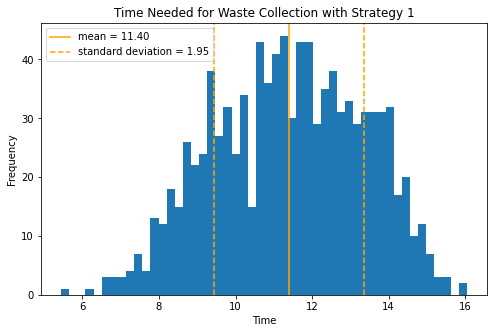

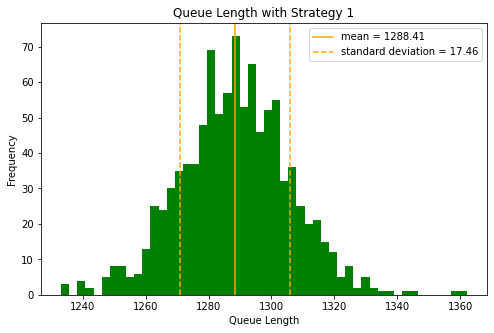

Average time needed for the 1st strategy: 11.403651962457396
Average time needed 95% confidence interval (9.450413828778998, 13.356890096135793)
Average queue length: 1288.4093915737426
Average queue length 95% confidence interval (1270.9541459478028, 1305.8646371996824)


In [123]:
# Plot the results and get the confidence interval

mean_strat_time = np.mean(average_service_time)
stdev_strat_time = np.std(average_service_time)

plt.figure(figsize=(8, 5))
plt.hist(average_service_time, bins = 50)
plt.title("Time Needed for Waste Collection with Strategy 1")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.axvline(mean_strat_time, color='orange',
            label=f'mean = {mean_strat_time:.2f}')
plt.axvline(mean_strat_time + stdev_strat_time, color='orange', linestyle='--',
            label=f'standard deviation = {stdev_strat_time:.2f}')
plt.axvline(mean_strat_time - stdev_strat_time, color='orange', linestyle='--')
plt.legend()
plt.show()


mean_strat_que = np.mean(average_queue_len)
stdev_strat_que = np.std(average_queue_len)

plt.figure(figsize=(8, 5))
plt.hist(average_queue_len, bins = 50, color = 'green')
plt.title("Queue Length with Strategy 1")
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.axvline(mean_strat_que, color='orange',
            label=f'mean = {mean_strat_que:.2f}')
plt.axvline(mean_strat_que + stdev_strat_que, color='orange', linestyle='--',
            label=f'standard deviation = {stdev_strat_que:.2f}')
plt.axvline(mean_strat_que - stdev_strat_que, color='orange', linestyle='--')
plt.legend()
plt.show()

print(f"Average time needed for the 1st strategy: {mean_strat_time}")
print(f"Average time needed 95% confidence interval {mean_strat_time - stdev_strat_time, mean_strat_time + stdev_strat_time}")

print(f"Average queue length: {mean_strat_que}")
print(f"Average queue length 95% confidence interval {mean_strat_que - stdev_strat_que, mean_strat_que + stdev_strat_que}")

In [117]:
# find the nodes with highest degree considering weights
order = sorted(farm_sites.degree(weight = "weight"), key = lambda x: x[1], reverse = True)
best_distribution = {}
nodes = list(farm_sites.nodes())

for i in range(best_number_of_stations):
    spot = order[i][0]
    nodes.remove(spot)
    best_distribution[spot] = True
    
for node in nodes:
    best_distribution[node] = False 

In [118]:
average_service_time = []
average_queue_len = []

# run the simulation for 1000 trials
for i in range(1000):
    
    # reset the network with the best distribution
    farm_sites = nx.Graph()
    
    for edge in connected_farms:
        farm_sites.add_edge(edge[0], edge[1], weight=find_weights(edge[0], edge[1]))
        
    for node in farm_sites.nodes():
        farm_sites.nodes[node]['population'] = node_population[node]
        farm_sites.nodes[node]['area'] = farm_sites_dict[node]
        farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
        farm_sites.nodes[node]['waste_truck'] = dis[node]

    # save the results
    out = run_waste_simulation(farm_sites, run_until=1000)
    average_service_time.append(np.mean(out.waste_collection_time))
    average_queue_len.append(np.mean(out.length_of_queue))

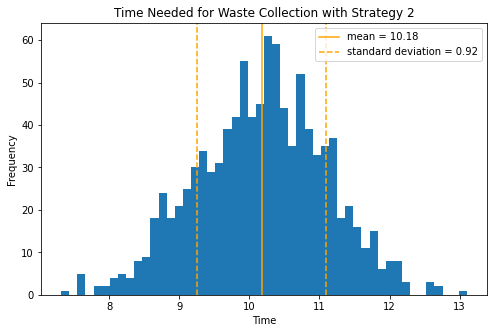

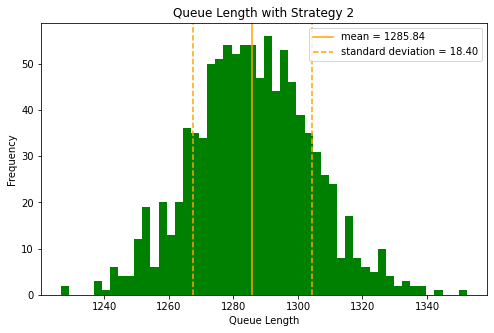

Average time needed for the 2nd strategy: 10.176008091625775
Average time needed 95% confidence interval (9.255292118913628, 11.096724064337922)
Average queue length: 1285.8372044178666
Average queue length 95% confidence interval (1267.4375317488718, 1304.2368770868613)


In [120]:
# plot the results and find the confidence interval

mean_strat_time = np.mean(average_service_time)
stdev_strat_time = np.std(average_service_time)

plt.figure(figsize=(8, 5))
plt.hist(average_service_time, bins = 50)
plt.title("Time Needed for Waste Collection with Strategy 2")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.axvline(mean_strat_time, color='orange',
            label=f'mean = {mean_strat_time:.2f}')
plt.axvline(mean_strat_time + stdev_strat_time, color='orange', linestyle='--',
            label=f'standard deviation = {stdev_strat_time:.2f}')
plt.axvline(mean_strat_time - stdev_strat_time, color='orange', linestyle='--')
plt.legend()
plt.show()


mean_strat_que = np.mean(average_queue_len)
stdev_strat_que = np.std(average_queue_len)

plt.figure(figsize=(8, 5))
plt.hist(average_queue_len, bins = 50, color = 'green')
plt.title("Queue Length with Strategy 2")
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.axvline(mean_strat_que, color='orange',
            label=f'mean = {mean_strat_que:.2f}')
plt.axvline(mean_strat_que + stdev_strat_que, color='orange', linestyle='--',
            label=f'standard deviation = {stdev_strat_que:.2f}')
plt.axvline(mean_strat_que - stdev_strat_que, color='orange', linestyle='--')
plt.legend()
plt.show()


print(f"Average time needed for the 2nd strategy: {mean_strat_time}")
print(f"Average time needed 95% confidence interval {mean_strat_time - stdev_strat_time, mean_strat_time + stdev_strat_time}")

print(f"Average queue length: {mean_strat_que}")
print(f"Average queue length 95% confidence interval {mean_strat_que - stdev_strat_que, mean_strat_que + stdev_strat_que}")